# Counteracting Overfitting

Overfitting is the primary cause of model innacuracy. When a model is overfitted, it performs well when predicting the class of images on which it has been trained; but does not generalize well to new images.

## Techniques for Avoiding Overfitting

There are a number of ways to address overfitting during the training process. In this notebook, we'll look at two of the most common approaches.

### Dropping Feature Maps

The first approach is somewhat counter-intuitive, but very effective. During the training process, the convolution and pooling layers in the feature extraction section of the model generate lots of feature maps from the training images. Randomly dropping some of these feature maps helps vary the features that are extracted in each batch, ensuring the model doesn't become overly-reliant on any one dominant feature in the training data.

### Data Augmentation

In an ideal world, you'd have a huge volume of training data that is representative of all future data that you will submit to the model for inference. In reality, you must often traing a model with a limited set of training data, which can exacerbate the overfitting problem. One way to mitigate this is to perform data augmentation by making random transformations of the training images; for example by flipping, rotating, or cropping them. Because you randomly apply these data augmentation transformations during training, the same image might be presented differently from batch to batch, creating more variation in the training data and helping the model to learn features based the same objects at different orientations or scales.

## Adding Drop Layers and Data Augementation to a CNN

Let's take a look at using these techniques when training a Keras model. First, we'll import the latest version of Keras and prepare to load our training data.

In [1]:
!pip install --upgrade keras

import sys
import keras
from keras import backend as K
import os

print('Keras version:',keras.__version__)

# The images are in a folder named 'shapes/training'
training_folder_name = '../data/shapes/training'

# All images are 128x128 pixels
img_size = (128,128)

# The folder contains a subfolder for each class of shape
classes = sorted(os.listdir(training_folder_name))
print(classes)

     |████████████████████████████████| 378kB 2.9MB/s eta 0:00:01
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


Using TensorFlow backend.
/home/hugin/anaconda3/envs/baldur/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hugin/anaconda3/envs/baldur/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hugin/anaconda3/envs/baldur/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hugin/anaconda3/e

Keras version: 2.3.0
['circle', 'square', 'triangle']


/home/hugin/anaconda3/envs/baldur/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hugin/anaconda3/envs/baldur/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hugin/anaconda3/envs/baldur/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hugin/anaconda3/envs/b

### Augment the Data
Now we're ready to define our data loaders. At this point we can add transformations to randomly modify the images as they are added to a training batch. In this case, we'll flip images horizontally at random.

In [2]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 30

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255, # normalize pixel values
                             horizontal_flip=True, # Flip some images at random
                             validation_split=0.3) # hold back 30% of the images for validation

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    training_folder_name,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    training_folder_name,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data


Getting Data...
Preparing training dataset...
Found 840 images belonging to 3 classes.
Preparing validation dataset...
Found 360 images belonging to 3 classes.


### Add Drop Layers to the CNN
Now we're ready to define our model, which will include some drop layers to randomly drop some of the extracted features.

In [11]:
# Define a CNN classifier network
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.layers import Activation, Flatten, Dense
from keras import optimizers

# Define the model as a sequence of layers
model = Sequential()

# The input layer accepts an image and applies a convolution that uses 32 6x6 filters and a rectified linear unit activation function
model.add(Conv2D(32, (6, 6), input_shape=train_generator.image_shape, activation='relu'))

# Next we'll add a max pooling layer with a 2x2 patch
model.add(MaxPooling2D(pool_size=(2,2)))

# We can add as many layers as we think necessary - here we'll add another convolution layer and another and max poolinglayer
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# A dropout layer randomly drops some features to reduce inter-dependencies (which can cause over-fitting)
model.add(Dropout(0.3))

# Now we'll flatten the feature maps and generate an output layer with a predicted probability for each class
model.add(Flatten())
model.add(Dense(train_generator.num_classes, activation='softmax'))

# We'll use the ADAM optimizer
opt = optimizers.Adam(lr=0.001)

# With the layers defined, we can now compile the model for categorical (multi-class) classification
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 123, 123, 32)      3488      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 32)        36896     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                

### Train the Model

With the layers of the CNN defined, we're ready to train the model using our randomly augmented image data. Since we're dropping some features, it may require more epochs to get the loss to drop so that the model is reasonably accurate - but the data augmentation and dropped features should help ensure that as we train for more epochs, the validation loss drops along with the training loss; meaning that the model will generalize well.

In [15]:
# Train the model over 10 epochs
num_epochs = 10
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

Epoch 1/10
28/28 [==============================] - 7s 239ms/step - loss: 1.0082 - accuracy: 0.4976 - val_loss: 0.7811 - val_accuracy: 0.6917
Epoch 2/10
28/28 [==============================] - 6s 218ms/step - loss: 0.5225 - accuracy: 0.7857 - val_loss: 0.3774 - val_accuracy: 0.7917
Epoch 3/10
28/28 [==============================] - 6s 218ms/step - loss: 0.3001 - accuracy: 0.8631 - val_loss: 0.2742 - val_accuracy: 0.8611
Epoch 4/10
28/28 [==============================] - 6s 216ms/step - loss: 0.2379 - accuracy: 0.8964 - val_loss: 0.2566 - val_accuracy: 0.9361
Epoch 5/10
28/28 [==============================] - 6s 218ms/step - loss: 0.1650 - accuracy: 0.9381 - val_loss: 0.1257 - val_accuracy: 0.9667
Epoch 6/10
28/28 [==============================] - 6s 217ms/step - loss: 0.1389 - accuracy: 0.9429 - val_loss: 0.1486 - val_accuracy: 0.9778
Epoch 7/10
28/28 [==============================] - 6s 227ms/step - loss: 0.0817 - accuracy: 0.9810 - val_loss: 0.0617 - val_accuracy: 0.9972
Epoch 

### View the Loss History
We tracked average training and validation loss history for each epoch. We can plot these to verify that loss reduced as the model was trained, and to detect *over-fitting* (which is indicated by a continued drop in training loss after validation loss has levelled out or started to increase.

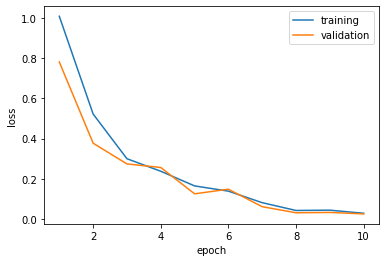

In [16]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### Save the Model
Now that we have trained the model, we can save it with the trained weights.

In [17]:
from keras.models import load_model

modelFileName = 'shape-classifier.h5'

model.save(modelFileName) # saves the trained model
print("Model saved.")

del model  # deletes the existing model variable

Model saved.


## Use the Model with New Data
Now that we've trained and evaluated our model, we can use it to predict classes for new images.

### Create Functions to Prepare Data and Get Class Predictions
Let's create a couple of functions to:

- Resize new images to match the size on which the model was trained.
- Submit the new images to the model and retrieve the predicted classes.

In [18]:
# Helper function to resize image
def resize_image(src_img, size=(128,128), bg_color="white"): 
    from PIL import Image

    # rescale the image so the longest edge is the right size
    src_img.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new image of the right shape
    new_image = Image.new("RGB", size, bg_color)
    
    # Paste the rescaled image onto the new background
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))
  
    # return the resized image
    return new_image

# Function to predict the class of an image
def predict_image(classifier, image_array):
    import numpy as np
    
    # We need to format the input to match the training data
    # The data generator loaded the values as floating point numbers
    # and normalized the pixel values, so...
    img_features = image_array.astype('float32')
    img_features /= 255
    
    # These are the classes our model can predict
    classnames = ['circle', 'square', 'triangle']
    
    # Predict the class of each input image
    predictions = classifier.predict(img_features)
    
    predicted_classes = []
    for prediction in predictions:
        # The prediction for each image is the probability for each class, e.g. [0.8, 0.1, 0.2]
        # So get the index of the highest probability
        class_idx = np.argmax(prediction)
        # And append the corresponding class name to the results
        predicted_classes.append(classnames[int(class_idx)])
    # Return the predictions
    return predicted_classes

print("Functions created - ready to use model for inference.")

Functions created - ready to use model for inference.


### Predict Image Classes
Now we're ready to use the model for predicting (often referred to as *inferencing*) the classes of some new images.

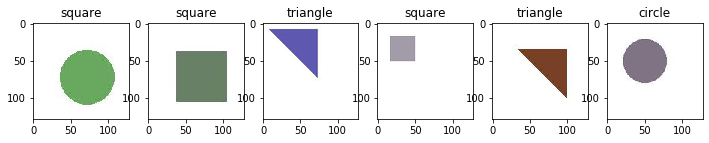

In [19]:
import os
from random import randint
import numpy as np
from PIL import Image
from keras.models import load_model
from matplotlib import pyplot as plt
%matplotlib inline

# load the saved model
modelFileName = 'shape-classifier.h5'
model = load_model(modelFileName) 

#get the list of test image files
test_folder = '../data/shapes/test'
test_image_files = os.listdir(test_folder)

# Empty array on which to store the images
image_arrays = []

size = (128,128)
background_color="white"

fig = plt.figure(figsize=(12, 8))

# Get the images and show the predicted classes
for file_idx in range(len(test_image_files)):
    img = Image.open(os.path.join(test_folder, test_image_files[file_idx]))
    
    # resize the image so it matches the training set - it  must be the same size as the images on which the model was trained
    resized_img = np.array(resize_image(img, size, background_color))
                      
    # Add the image to the array of images
    image_arrays.append(resized_img)

# Get predictions from the array of image arrays
# Note that the model expects an array of 1 or more images - just like the batches on which it was trained
predictions = predict_image(model, np.array(image_arrays))

# plot easch image with its corresponding prediction
for idx in range(len(predictions)):
    a=fig.add_subplot(1,len(predictions),idx+1)
    imgplot = plt.imshow(image_arrays[idx])
    a.set_title(predictions[idx])
